https://maurocamaraescudero.netlify.app/post/minimalist-variational-autoencoder-in-pytorch-with-cuda-gpu/

In [1]:
# Import libraries
import torchvision                             # contains image datasets and many functions to manipulate images
import torchvision.transforms as transforms    # to normalize, scale etc the dataset
from torch.utils.data import DataLoader        # to load data into batches (for SGD)
from torchvision.utils import make_grid        # Plotting. Makes a grid of tensors
from torchvision.datasets import MNIST         # the classic handwritten digits dataset
import matplotlib.pyplot as plt                # to plot our images
import numpy as np

# Create Dataset object.s Notice that ToTensor() transforms images to pytorch
# tensors AND scales the pixel values to be within [0, 1]. Also, we have separate Dataset
# objects for training and test sets. Data will be downloaded to a folder called 'data'.
trainset = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset  = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Create DataLoader objects. These will give us our batches of training and testing data.
batch_size = 100
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader  = DataLoader(testset, batch_size=batch_size, shuffle=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
import torch.nn as nn                          # Class that implements a model (such as a Neural Network)
import torch.nn.functional as F                # contains activation functions, sampling layers etc
import torch.optim as optim                    # For optimization routines such as SGD, ADAM, ADAGRAD, etc

In [4]:
e_hidden = 500        # Number of hidden units in the encoder. See AEVB paper page 7, section "Marginal Likelihood"
d_hidden = 500        # Number of hidden units in the decoder. See AEVB paper page 7, section "Marginal Likelihood"
latent_dim = 2        # Dimension of latent space. See AEVB paper, page 7, section "Marginal Likelihood"
learning_rate = 0.001 # For optimizer (SGD or Adam)
weight_decay = 1e-5   # For optimizer (SGD or Adam)
epochs = 50           # Number of sweeps through the whole datase

In [5]:
class VAE(nn.Module):
    def __init__(self):
        """Variational Auto-Encoder Class"""
        super(VAE, self).__init__()
        # Encoding Layers
        self.e_input2hidden = nn.Linear(in_features=784, out_features=e_hidden)
        self.e_hidden2mean = nn.Linear(in_features=e_hidden, out_features=latent_dim)
        self.e_hidden2logvar = nn.Linear(in_features=e_hidden, out_features=latent_dim)
        
        # Decoding Layers
        self.d_latent2hidden = nn.Linear(in_features=latent_dim, out_features=d_hidden)
        self.d_hidden2image = nn.Linear(in_features=d_hidden, out_features=784)
        
    def forward(self, x):
        # Shape Flatten image to [batch_size, input_features]
        x = x.view(-1, 784)
        
        # Feed x into Encoder to obtain mean and logvar
        x = F.relu(self.e_input2hidden(x))
        mu, logvar = self.e_hidden2mean(x), self.e_hidden2logvar(x)
        
        # Sample z from latent space using mu and logvar
        if self.training:
            z = torch.randn_like(mu).mul(torch.exp(0.5*logvar)).add_(mu)
        else:
            z = mu
        
        # Feed z into Decoder to obtain reconstructed image. Use Sigmoid as output activation (=probabilities)
        x_recon = torch.sigmoid(self.d_hidden2image(torch.relu(self.d_latent2hidden(z))))
        
        return x_recon, mu, logvar

In [6]:
# Loss
def vae_loss(image, reconstruction, mu, logvar):
  """Loss for the Variational AutoEncoder."""
  # Binary Cross Entropy for batch
  BCE = F.binary_cross_entropy(input=reconstruction.view(-1, 28*28), target=image.view(-1, 28*28), reduction='sum')
  # Closed-form KL Divergence
  KLD = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return BCE - KLD

# Instantiate VAE with Adam optimizer
vae = VAE()
vae = vae.to(device)    # send weights to GPU. Do this BEFORE defining Optimizer
optimizer = optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=weight_decay)
vae.train()            # tell the network to be in training mode. Useful to activate Dropout layers & other stuff

# Train
losses = []

for epoch in range(epochs):
  # Store training losses & instantiate batch counter
  losses.append(0)
  number_of_batches = 0

  # Grab the batch, we are only interested in images not on their labels
  for images, _ in trainloader:
    # Save batch to GPU, remove existing gradients from previous iterations
    images = images.to(device)
    optimizer.zero_grad()

    # Feed images to VAE. Compute Loss.
    reconstructions, latent_mu, latent_logvar = vae(images)
    loss = vae_loss(images, reconstructions, latent_mu, latent_logvar)

    # Backpropagate the loss & perform optimization step with such gradients
    loss.backward()
    optimizer.step()

    # Add loss to the cumulative sum
    losses[-1] += loss.item()  
    number_of_batches += 1
  
  # Update average loss & Log information
  losses[-1] /= number_of_batches
  print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, epochs, losses[-1]))    

Epoch [1 / 50] average reconstruction error: 18389.774207
Epoch [2 / 50] average reconstruction error: 16587.987562
Epoch [3 / 50] average reconstruction error: 16241.358053
Epoch [4 / 50] average reconstruction error: 16034.837655
Epoch [5 / 50] average reconstruction error: 15872.323962
Epoch [6 / 50] average reconstruction error: 15734.033387
Epoch [7 / 50] average reconstruction error: 15631.293691
Epoch [8 / 50] average reconstruction error: 15536.148910
Epoch [9 / 50] average reconstruction error: 15449.681623
Epoch [10 / 50] average reconstruction error: 15385.707523
Epoch [11 / 50] average reconstruction error: 15320.953307
Epoch [12 / 50] average reconstruction error: 15266.447026
Epoch [13 / 50] average reconstruction error: 15219.339067
Epoch [14 / 50] average reconstruction error: 15172.761330
Epoch [15 / 50] average reconstruction error: 15129.258481
Epoch [16 / 50] average reconstruction error: 15091.250352
Epoch [17 / 50] average reconstruction error: 15055.237498
Epoch 

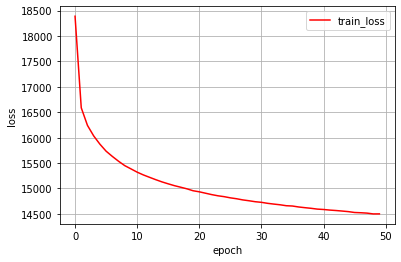

In [8]:
plt.figure()
plt.plot(range(epochs), losses, 'r-', label='train_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

ModuleAttributeError: ignored